In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
#from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
#from keras.layers import Embedding
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Rescaling,BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
print(tf.config.list_physical_devices('GPU'))
from keras import backend as K

2024-11-10 11:43:38.508471: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 11:43:38.523010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731235418.531202 1263768 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731235418.533666 1263768 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 11:43:38.542581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
def calculate_angle(vec1, vec2):
    dot_product = np.sum(vec1 * vec2, axis=1)
    mag1 = np.linalg.norm(vec1, axis=1)
    mag2 = np.linalg.norm(vec2, axis=1)
    cos_theta = dot_product / (mag1 * mag2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid domain errors
    return angle
def single_angle_trans(clk_time):
    time_rad = clk_time[:,0]/12*2*np.pi + clk_time[:,1]/60*np.pi/6
    time_per = np.array(np.round([np.cos(time_rad),
                                  np.sin(time_rad)],5)).T
    return time_per
def common_sense_err2(test_y,pred_y):
    sa1 = single_angle_trans(pred_y)
    sa2 = single_angle_trans(test_y)
    sa_diff = calculate_angle(sa1,sa2)
    hr_diff = sa_diff//(np.pi/6)
    min_diff = np.round((sa_diff%(np.pi/6)*6*60/np.pi))
    return np.array([hr_diff,min_diff]).T


In [2]:
images = np.load('s_images.npy')  # Shape (18000, 75, 75)
labels = np.load('s_labels.npy')  #shape (18000, 2)
print(labels)
def time_to_category(hour, minute):
    total_minutes = hour * 60 + minute
    return total_minutes // 30

def function_category(hour, minute,b):
    total_minutes = hour * 60 + minute
    return total_minutes // b

batch_size = 32
epochs = 50
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

[[ 0  0]
 [ 0  0]
 [ 0  0]
 ...
 [11 59]
 [11 59]
 [11 59]]


In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

tru_y = y_test

y_train = np.array([function_category(h, m,1) for h, m in y_train])
y_test = np.array([function_category(h, m,1) for h, m in y_test])
y_val = np.array([function_category(h, m,1) for h, m in y_val])
print(y_test)
# Convert labels to categorical format
y_train = tf.keras.utils.to_categorical(y_train, num_classes=720)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=720)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=720)

[170 604 618 ... 198  59 557]


In [4]:

K.clear_session()
model1 = Sequential([
    Rescaling(1./255, input_shape=(75, 75, 1)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(720, activation='softmax')  
])

model1.compile(optimizer= Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
his_1= model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks = [reduce_lr],
    verbose=1
)
test_loss1, test_accuracy1 = model1.evaluate(X_test, y_test, verbose=2)

/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1731235440.526436 1263768 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3642 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/50


I0000 00:00:1731235441.951861 1263901 service.cc:148] XLA service 0x7fe008014010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731235441.951884 1263901 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-10 11:44:01.979329: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731235442.096986 1263901 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-10 11:44:02.193210: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-11-10 11:44:0

 19/450 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0035 - loss: 9.9798   

I0000 00:00:1731235444.656566 1263901 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.0013 - loss: 9.4791 - val_accuracy: 0.0011 - val_loss: 8.2721 - learning_rate: 1.0000e-04
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0013 - loss: 7.9901 - val_accuracy: 0.0022 - val_loss: 7.3921 - learning_rate: 1.0000e-04
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0021 - loss: 7.2612 - val_accuracy: 0.0011 - val_loss: 7.0055 - learning_rate: 1.0000e-04
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0021 - loss: 6.9295 - val_accuracy: 0.0000e+00 - val_loss: 6.8375 - learning_rate: 1.0000e-04
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0026 - loss: 6.7693 - val_accuracy: 0.0011 - val_loss: 6.7595 - learning_rate: 1.0000e-04
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0033 - loss: 6.6871 - val_accuracy: 5.5556e-04 - val_loss: 6.7453 - learning_rate: 1.0000e-04
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.

Text(0.5, 1.0, 'Loss')

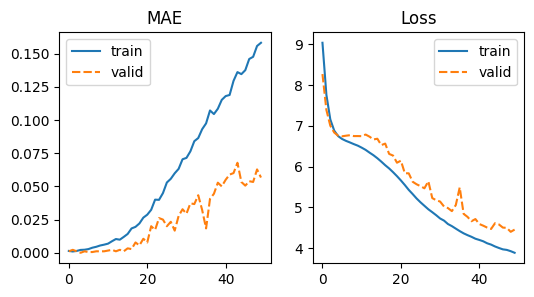

In [8]:
import pandas as pd
import seaborn as sns
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_1.history['accuracy']
mae_df['valid'] = his_1.history['val_accuracy']
loss_df['train'] = his_1.history['loss']
loss_df['valid'] = his_1.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")

In [5]:
def back_to_original(category, b):
    total_minutes = category * b
    hour = total_minutes // 60
    minute = total_minutes % 60
    return hour, minute

In [17]:
predictions_1 = model1.predict(X_test)
# print(predictions_1)
predicted_categories_1 = np.argmax(predictions_1, axis=1)
org_1 = back_to_original(predicted_categories_1,1)
Org_1 = np.column_stack((org_1[0], org_1[1])) 
print(tru_y[:3])
print(Org_1[:3])
tru_yhour = tru_y[:,0]
pred_y = Org_1[:,0]
acc_hour = np.sum(tru_yhour== pred_y) / len(tru_yhour)
print(acc_hour)

true_ymin = tru_y[:,1]
pred_ymin = Org_1[:,1]
acc_min = np.sum(true_ymin == pred_ymin) / len(true_ymin)
print(acc_min)
np.mean(common_sense_err2(tru_y,Org_1),axis=0)

 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[ 2 50]
 [10  4]
 [10 18]]
[[ 2 49]
 [10  7]
 [10 16]]
0.3888888888888889
0.07944444444444444


array([ 1.22666667, 20.73833333])

In [18]:
X_train30, X_temp30, y_train30, y_temp30 = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val30, X_test30, y_val30, y_test30 = train_test_split(X_temp30, y_temp30, test_size=0.5, random_state=42) 
true_y30 = y_test30
print(true_y30)
y_train30 = np.array([function_category(h, m,30) for h, m in y_train30])
y_test30 = np.array([function_category(h, m,30) for h, m in y_test30])
y_val30 = np.array([function_category(h, m,30) for h, m in y_val30])

# Convert labels to categorical format
y_train30 = tf.keras.utils.to_categorical(y_train30, num_classes=24)
y_val30 = tf.keras.utils.to_categorical(y_val30, num_classes=24)
y_test30 = tf.keras.utils.to_categorical(y_test30, num_classes=24)

[[ 2 50]
 [10  4]
 [10 18]
 ...
 [ 3 18]
 [ 0 59]
 [ 9 17]]


In [19]:
K.clear_session()
model30 = Sequential([
    Rescaling(1./255, input_shape=(75, 75, 1)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(24, activation='softmax') 
])

model30.compile(optimizer= Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model30.summary()

history= model30.fit(
    X_train30, y_train30,
    validation_data=(X_val30, y_val30),
    epochs=epochs,
    batch_size=batch_size,
    callbacks =[reduce_lr],
    verbose=1
)
test_loss, test_accuracy = model30.evaluate(X_test30, y_test30, verbose=2)

/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,920 (1.79 MB)

 Trainable params: 468,472 (1.79 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.0445 - loss: 6.4478 - val_accuracy: 0.0439 - val_loss: 5.6810 - learning_rate: 1.0000e-04
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0487 - loss: 5.3706 - val_accuracy: 0.0656 - val_loss: 4.7271 - learning_rate: 1.0000e-04
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0677 - loss: 4.5490 - val_accuracy: 0.1094 - val_loss: 4.0021 - learning_rate: 1.0000e-04
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1147 - loss: 3.8678 - val_accuracy: 0.1533 - val_loss: 3.4017 - learning_rate: 1.0000e-04
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1735 - loss: 3.3056 - val_accuracy: 0.2289 - val_loss: 2.9345 - learning_rate: 1.0000e-04
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2311 - loss: 2.9024 - val_accuracy: 0.2950 - val_loss: 2.6670 - learning_rate: 1.0000e-04
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy:

Text(0.5, 1.0, 'Loss')

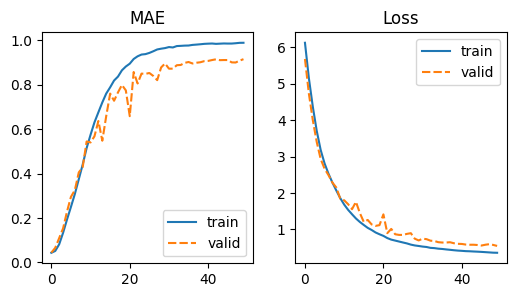

In [20]:
import pandas as pd
import seaborn as sns
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = history.history['accuracy']
mae_df['valid'] = history.history['val_accuracy']
loss_df['train'] = history.history['loss']
loss_df['valid'] = history.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")

In [22]:
predictions_30 = model30.predict(X_test30)
predicted_categories_30 = np.argmax(predictions_30, axis=1)
org_30 = back_to_original(predicted_categories_30,30)
Org_30 = np.column_stack((org_30[0], org_30[1])) 
print(Org_30)
tru30_yhour = true_y30[:,0]
pred_y30 = Org_30[:,0]
acc_hour30 = np.sum(tru30_yhour== pred_y30) / len(tru30_yhour)
print(acc_hour30)

true30_ymin = true_y30[:,1]
pred_ymin30 = Org_30[:,1]
acc_min30 = np.sum(true30_ymin == pred_ymin30) / len(true30_ymin)
print(acc_min30)
np.mean(common_sense_err2(tru_y,Org_30),axis=0)

 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[ 2 30]
 [10  0]
 [10  0]
 ...
 [ 3  0]
 [ 1  0]
 [ 9  0]]
0.9461111111111111
0.022222222222222223


array([ 0.02777778, 14.83444444])